# 04. User Animelist Dataset
ここからは、今まで触れてこなかった**ジャンル**属性に関する分析を行いたい。

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import ast
import matplotlib as mpl

In [2]:
# グラフ画像保存用パラメータ
mpl.rcParams["figure.dpi"] = 80
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.figsize"] = (8, 6)
output_dir = Path("..", "output")

In [3]:
ratings = pd.read_pickle(Path("..", "data", "processed", "merged.pkl"))

In [4]:
ratings.head(3)

,userID,animeID,rating,type,year,episodes,sequel
0,1,1,10,MOVIE,2004,1,False
1,1,2,10,TV,2006,37,False
2,1,3,7,TV,2013,10,False


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148170496 entries, 0 to 148170495
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   userID    int32   
 1   animeID   int16   
 2   rating    int8    
 3   type      category
 4   year      Int16   
 5   episodes  int16   
 6   sequel    bool    
dtypes: Int16(1), bool(1), category(1), int16(2), int32(1), int8(1)
memory usage: 1.9 GB


In [6]:
animes = pd.read_pickle(Path("..", "data", "processed", "animes.pkl"))

In [7]:
animes.head(3)

,animeID,title,alternative_title,score,episodes,image_url,genres,genres_detailed
0,1,Howl's Moving Castle,Howl no Ugoku Shiro,8.41,1,https://cdn.myanimelist.net/images/anime/1470/...,"['Adventure', 'Award Winning', 'Drama', 'Fanta...","['action', 'adventure', 'age gap', 'air force'..."
1,2,Death Note,NaN,8.63,37,https://cdn.myanimelist.net/images/anime/1079/...,"['Supernatural', 'Suspense']","['achronological order', 'acting', 'adapted in..."
2,3,Problem Children Are Coming from Another World...,Mondaiji-tachi ga Isekai kara Kuru Sou desu yo?,7.42,10,https://cdn.myanimelist.net/images/anime/12/43...,"['Action', 'Comedy', 'Fantasy']","['action', 'alternative world', 'anthropomorph..."


In [8]:
animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20237 entries, 0 to 20236
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   animeID            20237 non-null  int16  
 1   title              20237 non-null  object 
 2   alternative_title  8676 non-null   object 
 3   score              19644 non-null  float32
 4   episodes           20237 non-null  int16  
 5   image_url          20237 non-null  object 
 6   genres             20237 non-null  object 
 7   genres_detailed    20237 non-null  object 
dtypes: float32(1), int16(2), object(5)
memory usage: 948.7+ KB


## genres列の引き延ばし
方針としては、`animes`テーブルの`genres`列に対して、`explode`メソッドを使用してデータの引き延ばしを行う。<br>
そこへさらに、`ratings`テーブルの情報を結合処理するため、結果は膨大な情報量になると想定できる。<br>
そのため、処理落ちを防ぐために、極限まで必要最低限の情報にそぎ落としていく作業を行う。

In [9]:
animes_genres = animes[["animeID", "genres"]].copy()
animes_genres

,animeID,genres
0,1,"['Adventure', 'Award Winning', 'Drama', 'Fanta..."
1,2,"['Supernatural', 'Suspense']"
2,3,"['Action', 'Comedy', 'Fantasy']"
3,4,"['Action', 'Sci-Fi', 'Suspense']"
4,5,"['Action', 'Adventure', 'Fantasy', 'Romance']"
...,...,...
20232,20233,['Fantasy']
20233,20234,['Fantasy']
20234,20235,['Fantasy']
20235,20236,[]


In [10]:
# "genres"列の型をPythonのリストに変換する事で、explodeメソッドが使えるようにする
animes_genres["genres"] = animes_genres["genres"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [11]:
type(animes_genres.loc[0, "genres"])

list

explodeメソッドを実行し、複数のジャンルをそれぞれ1行ずつ引き延ばす

In [12]:
exploded = animes_genres.explode("genres")

In [13]:
exploded

,animeID,genres
0,1,Adventure
0,1,Award Winning
0,1,Drama
0,1,Fantasy
0,1,Romance
...,...,...
20232,20233,Fantasy
20233,20234,Fantasy
20234,20235,Fantasy
20235,20236,NaN


この時点で、作品ごとのジャンルの要素数の構成を確認し、可視化したい

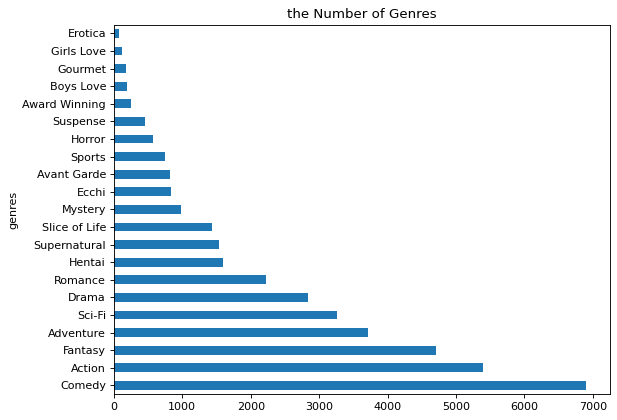

In [14]:
exploded["genres"].value_counts().plot(
    kind="barh", title="the Number of Genres"
)
plt.savefig(output_dir / "13_the Number of Genres.png")
plt.show()

最も多いジャンルは`Comedy`、続いて`Action`、`Fantasy`となっている。

軽量化の作業に戻る。`"genres"`列をカテゴリ型に変えることで軽量化を試みる。

In [15]:
# 軽量化を試みるために、"genres"列をカテゴリ型に変えてみる
exploded["genres"] = exploded["genres"].astype("category")

では、ここに`ratings`テーブルを結合する事で、ジャンル属性に関する分析を実行したい。<br>
この際、結合する情報をしっかりと取捨選択する。

In [16]:
ratings.head()

,userID,animeID,rating,type,year,episodes,sequel
0,1,1,10,MOVIE,2004,1,False
1,1,2,10,TV,2006,37,False
2,1,3,7,TV,2013,10,False
3,1,4,10,TV,2012,12,False
4,1,5,10,TV,2012,25,False


In [17]:
ratings_genres = ratings[["animeID", "rating"]].copy()

In [18]:
exploded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39078 entries, 0 to 20236
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   animeID  39078 non-null  int16   
 1   genres   38822 non-null  category
dtypes: category(1), int16(1)
memory usage: 420.5 KB


In [19]:
ratings_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148170496 entries, 0 to 148170495
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   animeID  int16
 1   rating   int8 
dtypes: int16(1), int8(1)
memory usage: 423.9 MB


In [20]:
merged = pd.merge(exploded, ratings_genres, on="animeID")

In [21]:
merged.head()

,animeID,genres,rating
0,1,Adventure,10
1,1,Adventure,10
2,1,Adventure,10
3,1,Adventure,9
4,1,Adventure,8


In [22]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388998092 entries, 0 to 388998091
Data columns (total 3 columns):
 #   Column   Dtype   
---  ------   -----   
 0   animeID  int16   
 1   genres   category
 2   rating   int8    
dtypes: category(1), int16(1), int8(1)
memory usage: 1.4 GB


`genres`列をカテゴリ型にすることで、2.6GBものメモリの節約に成功した。<br>
今後のために、ひとまずこのテーブルを保存しておく。

In [23]:
merged.to_pickle(Path("..", "data", "processed", "genre_rate.pkl"))

### ジャンル属性による分析
では早速、このデータを用いてジャンルに関する分析を実行する。

In [24]:
grouped = merged.groupby("genres", observed=True)

ジャンルごとの評価件数のグラフを確認する。<br>
以下のコードでは、件数と平均を同時に集計している。

In [25]:
genres_agg = grouped["rating"].agg(
    ["size", "mean"]
).sort_values(ascending=False, by="size")

In [26]:
genres_agg

,size,mean
genres,,
Action,71584938,7.689886
Comedy,46038870,7.460852
Fantasy,44089159,7.530193
Drama,37167747,7.912606
Romance,34281951,7.428019
Adventure,32226710,7.694028
Supernatural,22622572,7.781681
Sci-Fi,20578442,7.556806
Suspense,18537691,7.907035


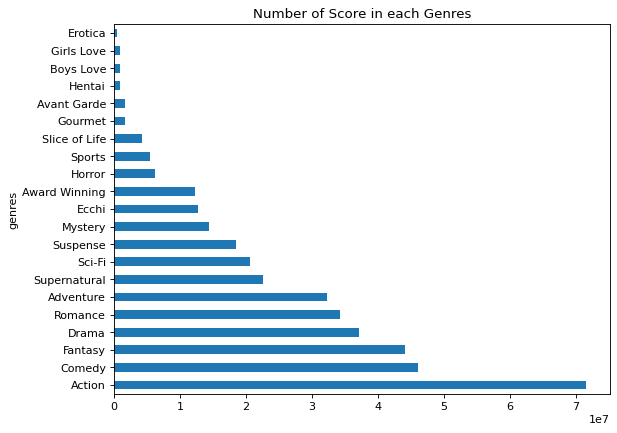

In [27]:
genres_agg["size"].plot(
    kind="barh",
    title="Number of Score in each Genres"
)
plt.savefig(output_dir / "14_Number of Score in each Genres.png")
plt.show()

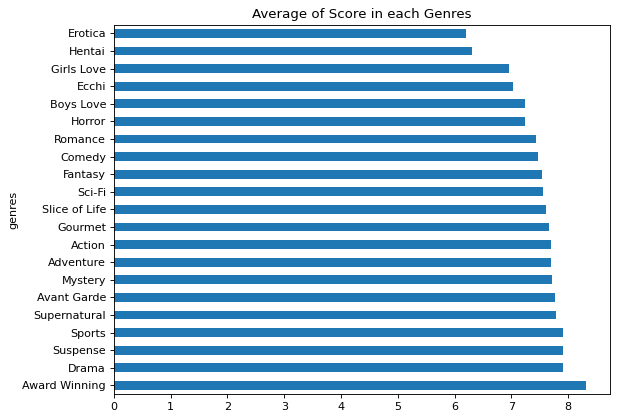

In [28]:
genres_agg["mean"].sort_values(ascending=False).plot(
    kind="barh",
    title="Average of Score in each Genres"
)
plt.savefig(output_dir / "15_Average of Score in each Genres.png")
plt.show()

### まとめ
- 多くの評価が投稿されるジャンルとしては、最も多いのが`Action`、続いて`Comedy`、`Fantasy`だった。こういった見やすく、親しみやすいジャンルの人気が高いと考えられる。
- `Comedy`のジャンルを含む作品が一番多い一方で、`Action`ジャンルに対する評価件数が一番多くなっている事から、このジャンルの関心の高さがうかがえる。
- `Ecchi`、`Hentai`、`Boys Love`といった性的な内容を示すジャンルは、それ自体が少なくとも意見を交換したり、活発な議論を呼ぶような要素ではないと考えられる。